## Imports

In [1]:
#Versión para tweepy V2
from datetime import date, datetime, timedelta
import datetime
import requests
import json
import time
from pathlib import Path
import math
import pymongo
from bson import ObjectId
import numpy as np
from datetime import date
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
from shapely import geometry, ops
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Dictionaries

In [2]:
user_dictionary = {
    "_id"               : None,
    "description"       : '',
    "created_at"        : '',
    "verified"          : '',
    "followers_count"   : 0,
    "following_count"   : 0
}


tweet_dictionary = {
    "_id"               : None,
    "author_id"         : '',
    "created_at"        : '',
    "text"              : '',
    "hashtag"           : [],
    "referenced_tweets" : [],
    "retweet_count"     : 0,
    "reply_count"       : 0,
    "reply_count"       : 0,
    "like_count"        : 0
}


node = {
    "hashtag"           : '',
    "current_date"        : '',
    "next_date"        : '',
    "next_token"        : '-1'
}

## Support functions

In [3]:
def DayMonthYearToPetition(date):
    """
    """
    splited = ''
    if ('/' in date):
        splited = date.split('/')
    elif ('-' in date):
        splited = date.split('-')
        
    return (splited[2] + '-' + splited[1] + '-' + splited[0])

def DayMonthYearToPetition(date):
    """
    """
    splited = ''
    if ('/' in date):
        splited = date.split('/')
    elif ('-' in date):
        splited = date.split('-')

    return (splited[2] + '-' + splited[1] + '-' + splited[0])

def PetitionToDayMonthYear(petition):
    """
    """
    splited = ''
    time = ''
    splited = petition.split('T')
    time = splited[1]
    splited = splited[0].split('-')
    return (splited[2] + '-' + splited[1] + '-' + splited[0] + 'T' + time)

def IsUnknown(user_id, user_list):
    for user in user_list:
        if (str(user['_id']) == str(user_id)):
            return False
    return True

def NextDate(current_date):
    '''
        current_date: D'ia de entrada
        return: Devuelve el d'ia siguiente al d'ia actual
    '''
    dat = datetime.datetime.strptime(current_date, "%d/%m/%Y")
    dat += datetime.timedelta(days=1)
    return dat.strftime("%d/%m/%Y").split(' ')[0]

def truncate(n):
    s = str(float(n)).split('.')
    return int(s[0])


## Experimentation

### Daily numbers of tweets and retweets with annotation of important external events.

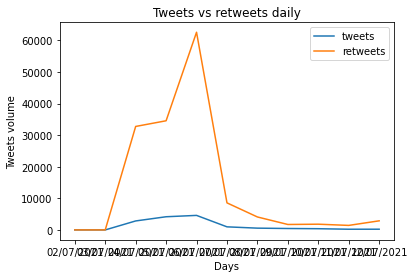

<Figure size 648x216 with 0 Axes>

[0, 0, 2839, 4167, 4596, 974, 559, 447, 383, 217, 226]
[0, 0, 32745, 34541, 62560, 8561, 4098, 1720, 1811, 1429, 2876]


In [17]:
def DailyTweetsAndRetweets(start, end):
    myclient = pymongo.MongoClient('localhost', 27017)
    mydb = myclient["mydatabase"]
    myusers = mydb["users"]
    mytweets = mydb["tweets"]
    current_date = start
    today = ''
    list_days = []
    list_day_tweet_count = []
    list_day_retweet_count = []
    while current_date != end:
        day = DayMonthYearToPetition(current_date) + 'T00:00:0.000Z'
        gte = datetime.datetime.strptime(day, '%Y-%m-%dT%H:%M:%S.%fZ')

        day = DayMonthYearToPetition(current_date) + 'T11:59:59.000Z'
        lt = datetime.datetime.strptime(day, '%Y-%m-%dT%H:%M:%S.%fZ')
        
        tweets_not_retweets = len(list(mytweets.find( {"$and": [ { "referenced_tweets.type" : {"$ne": "retweeted"} }, { "created_at" : { '$gte' : gte , '$lt' : lt }} ] } )))
        tweets_retweets = len(list(mytweets.find( {"$and": [ {"referenced_tweets.type" : "retweeted"}, {"created_at" : { '$gte' : gte , '$lt' : lt }} ] } )))
        
        list_days.append(current_date)
        list_day_tweet_count.append(tweets_not_retweets)
        list_day_retweet_count.append(tweets_retweets)
        current_date = NextDate(current_date)
    #print plot here
    plt.plot(list_days, list_day_tweet_count, label = "tweets")
    # plotting the line 2 points 
    plt.plot(list_days, list_day_retweet_count, label = "retweets")

    # naming the x axis
    plt.xlabel('Days')
    # naming the y axis
    plt.ylabel('Tweets volume')
    # giving a title to my graph
    plt.title('Tweets vs retweets daily')
    # show a legend on the plot
    plt.legend()
    plt.figure(figsize = (9, 3))
    # function to show the plot
    plt.show()
    print(list_day_tweet_count)
    print(list_day_retweet_count)
    
DailyTweetsAndRetweets("02/07/2021", "13/07/2021")

### Top-10 most tweeted and retweeted keywords.

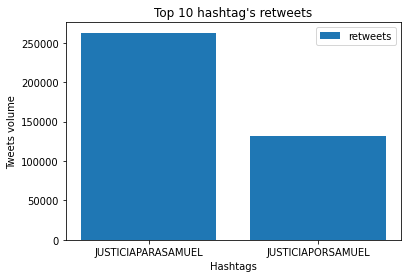

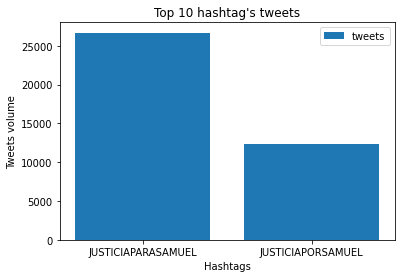

[26674, 12368]
[262840, 131566]


In [21]:
def Top10MostTweetsAndRetweets():
    myclient = pymongo.MongoClient('localhost', 27017)
    mydb = myclient["mydatabase"]
    myusers = mydb["users"]
    mytweets = mydb["tweets"]
    
    hashtag_retweet = {}
    hashtag_tweet = {}

    list_hashtags = []
    list_hashtag_retweet = []
    list_hashtag_tweet = []
    hashtags_list = []
    hashtag = ''
    
    f =  open("./hashtags.txt", "r")
    while True:
        # read line
        try:
            hashtag = f.readline()
            if (hashtag == "") :
                break
        except:
            # datetime object containing current date and time
            now = datetime.datetime.now()
            # dd/mm/YY H:M:S
            dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
            errorlog = open("./errorlog" + d1 + ".txt", "a")
            errorlog.write("Fallo al leer el fichero hashtags.txt " + dt_string + "\n")
            errorlog.close()

        hashtag = hashtag.rstrip('\n')
        hashtag = hashtag.replace('#', '')
        hashtags_list.append(hashtag.upper())
        
    f.close()
    
    for h in hashtags_list:
        
        tweets_not_retweets = len(list(mytweets.find( { "$and": [ {"referenced_tweets.type" : {"$ne": "retweeted"} }, { "hashtag": h } ] } )))
        tweets_retweets = len(list(mytweets.find( { "$and": [ {"referenced_tweets.type" : "retweeted"}, {"hashtag" : h  } ] } )))
        
        hashtag_retweet[h] = tweets_retweets
        hashtag_tweet[h] = tweets_not_retweets
                        
    sort_hashtag_retweet = sorted(hashtag_retweet.items(), key=lambda x: x[1], reverse=True)
    sort_hashtag_tweet = sorted(hashtag_tweet.items(), key=lambda x: x[1], reverse=True)
    
    for node in sort_hashtag_retweet[0:10]:
        list_hashtag_retweet.append(node[1])
        list_hashtags.append(node[0])
    #print plot here
    plt.figure(0)
    plt.bar(list_hashtags, list_hashtag_retweet, label = "retweets")
    # naming the x axis
    plt.xlabel('Hashtags')
    # naming the y axis
    plt.ylabel('Tweets volume')
    # giving a title to my graph
    plt.title("Top 10 hashtag's retweets")
    # show a legend on the plot
    plt.legend()
    
    list_hashtags = []
    if len(sort_hashtag_tweet) > 10:
        for node in sort_hashtag_tweet[0:10]:
            list_hashtag_tweet.append(node[1])
            list_hashtags.append(node[0])
    else:
        for node in sort_hashtag_tweet:
            list_hashtag_tweet.append(node[1])
            list_hashtags.append(node[0])
            
    # plotting the line 2 points 
    plt.figure(1)
    plt.bar(list_hashtags, list_hashtag_tweet, label = "tweets")
    # naming the x axis
    plt.xlabel('Hashtags')
    # naming the y axis
    plt.ylabel('Tweets volume')
    # giving a title to my graph
    plt.title("Top 10 hashtag's tweets")
    # show a legend on the plot
    plt.legend()
    
    # function to show the plot
    plt.show()
    print(list_hashtag_tweet)
    print(list_hashtag_retweet)
    
Top10MostTweetsAndRetweets()

### Word clouds with the top-100 most popular words in numbers of tweets and retweets.

In [ ]:
# https://www.datacamp.com/community/tutorials/wordcloud-python

### Keywords popularity over the weeks.

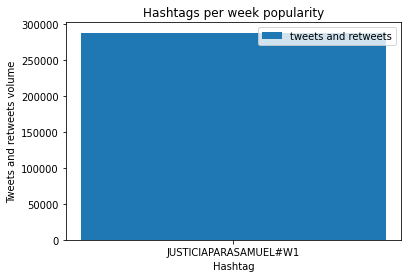

['JUSTICIAPARASAMUEL#W1']
[287673]


In [23]:
def datespan(startDate, endDate):
    current_date = startDate
    dat = datetime.datetime.strptime(current_date, "%d/%m/%Y")
    dat += datetime.timedelta(days= (6 - dat.weekday()))
    next_date = dat.strftime("%d/%m/%Y").split(' ')[0]
    if datetime.datetime.strptime(current_date, "%d/%m/%Y") < datetime.datetime.strptime(endDate, "%d/%m/%Y"):
        return endDate
    else: 
        return next_date

def HashtagsPerWeekPopularity(startDate, endDate):
    myclient = pymongo.MongoClient('localhost', 27017)
    mydb = myclient["mydatabase"]
    myusers = mydb["users"]
    mytweets = mydb["tweets"]
    
    current_date = startDate
    next_date = ''
    hashtags_list = []
    
    hashtag_count = {}
    
    hashtags_plt = []
    count_plt = []
    f =  open("./hashtags.txt", "r")
    while True:
        # read line
        try:
            hashtag = f.readline()
            if (hashtag == "") :
                break
        except:
            # datetime object containing current date and time
            now = datetime.datetime.now()
            # dd/mm/YY H:M:S
            dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
            errorlog = open("./errorlog" + d1 + ".txt", "a")
            errorlog.write("Fallo al leer el fichero hashtags.txt " + dt_string + "\n")
            errorlog.close()

        hashtag = hashtag.rstrip('\n')
        hashtag = hashtag.replace('#', '')
        hashtags_list.append(hashtag.upper())

    f.close()
    
    gte = ''
    lt = ''
    week_count = 1
    while current_date != endDate:
        next_date = datespan(current_date, endDate)
        for h in hashtags_list:
            day = DayMonthYearToPetition(current_date) + 'T00:00:0.000Z'
            gte = datetime.datetime.strptime(day, '%Y-%m-%dT%H:%M:%S.%fZ')
            day = DayMonthYearToPetition(next_date) + 'T00:00:0.000Z'
            lt = datetime.datetime.strptime(day, '%Y-%m-%dT%H:%M:%S.%fZ')
            hashtag_count[h] = len(list(mytweets.find( { "$and": [ { 'hashtag' : h }, { 'created_at' : { '$gte' : gte , '$lt' : lt } } ] } )))
        #aqui obtenemos el hashtag con mayor cantida de tweets y retweets y lo insertamos en la lista final
        sort_hashtag_count = sorted(hashtag_count.items(), key=lambda x: x[1], reverse=True)
        hashtags_plt.append(sort_hashtag_count[0][0] + '#W' + str(week_count))
        count_plt.append(sort_hashtag_count[0][1])
        current_date = next_date
        hashtag_count = {}
        week_count += 1
        gte = ''
        lt = ''
        
        
    plt.bar(hashtags_plt, count_plt, label = "tweets and retweets")
    # naming the x axis
    plt.xlabel('Hashtag')
    # naming the y axis
    plt.ylabel('Tweets and retweets volume')
    # giving a title to my graph
    plt.title("Hashtags per week popularity")
    # show a legend on the plot
    plt.legend()

    # function to show the plot
    plt.show()
    
   
    print(hashtags_plt)
    print(count_plt)
            

HashtagsPerWeekPopularity("02/07/2021", "13/07/2021")

### Distributions of the number of tweets and retweets per Twitter account.

In [ ]:
def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

def plot_ecdf(a):
    x, y = ecdf(a)
    x = np.insert(x, 0, x[0])
    y = np.insert(y, 0, 0.)
    plt.plot(x, y, drawstyle='steps-post')
    plt.grid(True)
    #plt.savefig('ecdf.png')
# no s'e si funciona
def DistributionTweetRetweetAccounts():
    myclient = pymongo.MongoClient('localhost', 27017)
    mydb = myclient["mydatabase"]
    myusers = mydb["users"]
    mytweets = mydb["tweets"]
    
    user_retweet_count = []
    user_tweet_count = []

    try:
        tweets = list(mytweets.find())
        users = list(myusers.find())
    except Exception as e:        
        pass
    
    list_hashtags = []
    list_hashtag_retweet = []
    list_hashtag_tweet = []
    
    for u in users:
        tweets_not_retweets = len(list(mytweets.find( { "$and": [ {"referenced_tweets.type" : {"$ne": "retweeted"} }, { "author_id": u['_id'] } ] } )))
        tweets_retweets = len(list(mytweets.find( { "$and": [ {"referenced_tweets.type" : "retweeted"}, {"author_id": u['_id'] } ] } )))
        
        user_retweet_count.append(tweets_retweets)
        user_tweet_count.append(tweets_not_retweets)
    
    xvec = np.array(user_retweet_count)
    plot_ecdf(xvec)
    
    xvec = np.array(user_tweet_count)
    plot_ecdf(xvec)
    
    print(list_hashtag_tweet)
    print(list_hashtag_retweet)
    
DistributionTweetRetweetAccounts()

### Top-5 most active verified user accounts.

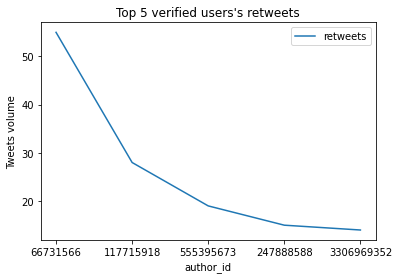

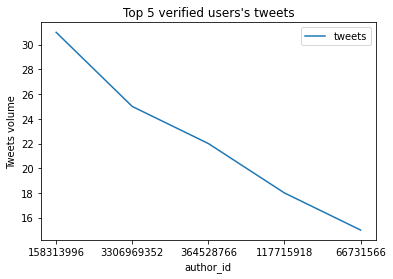

[(ObjectId('000000000000000158313996'), 31), (ObjectId('000000000000003306969352'), 25), (ObjectId('000000000000000364528766'), 22), (ObjectId('000000000000000117715918'), 18), (ObjectId('000000000000000066731566'), 15)]
[(ObjectId('000000000000000066731566'), 55), (ObjectId('000000000000000117715918'), 28), (ObjectId('000000000000000555395673'), 19), (ObjectId('000000000000000247888588'), 15), (ObjectId('000000000000003306969352'), 14)]


In [24]:
def Top5VerifiedUserTweets():
    myclient = pymongo.MongoClient('localhost', 27017)
    mydb = myclient["mydatabase"]
    myusers = mydb["users"]
    mytweets = mydb["tweets"]
    
    users = []
    user_retweet = {}
    user_tweet = {}
    
    try:
        users = list(myusers.find( { "verified" : True } ))
    except Exception as e:        
        pass

    list_user = []
    list_user_retweet = []
    list_user_tweet = []
    
    for u in users:
        tweets_not_retweets = len(list(mytweets.find( { "$and": [ {"referenced_tweets.type" : {"$ne": "retweeted"} }, { "author_id": u['_id'] } ] } )))
        tweets_retweets = len(list(mytweets.find( { "$and": [ {"referenced_tweets.type" : "retweeted"}, {"author_id": u['_id'] } ] } )))
        user_retweet[u['_id']] = tweets_retweets
        user_tweet[u['_id']] = tweets_not_retweets
                        
    sort_user_retweet = sorted(user_retweet.items(), key=lambda x: x[1], reverse=True)
    sort_user_tweet = sorted(user_tweet.items(), key=lambda x: x[1], reverse=True)
    
    
    for node in sort_user_retweet[0:5]:
        list_user_retweet.append(node[1])
        list_user.append(str(node[0]).lstrip("0"))
    # plotting the line 2 points 
    plt.figure(1)
    plt.plot(list_user, list_user_retweet, label = "retweets")
    # naming the x axis
    plt.xlabel('author_id')
    # naming the y axis
    plt.ylabel('Tweets volume')
    # giving a title to my graph
    plt.title("Top 5 verified users's retweets")
    # show a legend on the plot
    plt.legend()
    
    list_user = []
    for node in sort_user_tweet[0:5]:
        list_user_tweet.append(node[1])
        list_user.append(str(node[0]).lstrip("0"))
    #print plot here
    plt.figure(0)
    plt.plot(list_user, list_user_tweet, label = "tweets")
    # naming the x axis
    plt.xlabel('author_id')
    # naming the y axis
    plt.ylabel('Tweets volume')
    # giving a title to my graph
    plt.title("Top 5 verified users's tweets")
    # show a legend on the plot
    plt.legend()
    
    # function to show the plot
    plt.show()

    print(sort_user_tweet[0:5])
    print(sort_user_retweet[0:5])
    
Top5VerifiedUserTweets()

### Co-occurrence networks for tweets and retweets.

### Top-20 LIWC attributes extracted from the collected tweets and retweets.

### Heat map

1649
[2, 13, 0, 0, 47, 30, 10, 118, 499, 135, 115, 92, 203, 27, 32, 0, 34, 0, 1, 197]


<AxesSubplot:>

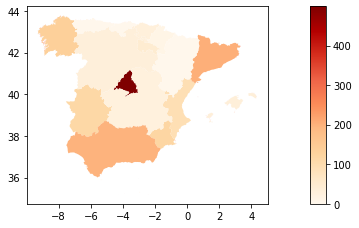

In [25]:
myclient = pymongo.MongoClient('localhost', 27017)
mydb = myclient["mydatabase_ejemplos"]
myusers = mydb["users_ejemplos"]
mytweets = mydb["tweets_ejemplos"]

tweet_list = list(mytweets.find( {'$and': [{ "place" : {"$ne": ""}}, {'geo.country': 'España'}] }))
print(str(len(tweet_list)))


# set the filepath and load
fp = 'recintos_autonomicas_inspire_peninbal_etrs89.shp'
#reading the file stored in variable fp
map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe

list_comunidades_count = [0 for i in range(len(map_df.NAMEUNIT))]



for tweet in tweet_list:
    index = 0
    while index < len(map_df.NAMEUNIT):
        line = LineString([(tweet['geo']['geo']['bbox'][0], tweet['geo']['geo']['bbox'][1]), (tweet['geo']['geo']['bbox'][2], tweet['geo']['geo']['bbox'][3])])
        if line.distance(map_df.geometry[index]) < 0.6:
            list_comunidades_count[index] = list_comunidades_count[index] + 1
            break
        index += 1

print(list_comunidades_count)
map_df['count_tweets'] = list_comunidades_count
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
map_df.plot(column='count_tweets', ax=ax, legend=True, cax=cax, cmap='OrRd')
    